In [1]:
from itertools import product
import graspy as gp
import numpy as np
import pandas as pd
from hyppo.ksample import KSample
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm_notebook as tqdm

from src import estimate_embeddings
%matplotlib inline

/home/ubuntu/env/miniconda3/envs/dnd/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def generate_graphs_1(p, effect_size, block_size, num_graphs):
    total_n = block_size * 2

    n = [block_size, block_size]
    B = [
        [p, p],
        [p, p + effect_size]
    ]
    
    X = np.array([gp.simulations.er_np(total_n, p) for _ in range(num_graphs)])
    Y = np.array([gp.simulations.sbm(n, B) for _ in range(num_graphs)])
    
    return X, Y

def generate_graphs_2(p, effect_size, block_size, num_graphs):
    total_n = block_size * 2

    n = [block_size, block_size]
    B = [
        [p, p + effect_size],
        [p + effect_size, p]
    ]
    
    X = np.array([gp.simulations.er_np(total_n, p) for _ in range(num_graphs)])
    Y = np.array([gp.simulations.sbm(n, B) for _ in range(num_graphs)])
    
    return X, Y

def generate_graphs_3(p, effect_size, block_size, num_graphs):
    total_n = block_size * 2

    n = [block_size, block_size]
    B = [
        [p, p + (effect_size / 2)],
        [p + (effect_size / 2), p + effect_size]
    ]
    
    X = np.array([gp.simulations.er_np(total_n, p) for _ in range(num_graphs)])
    Y = np.array([gp.simulations.sbm(n, B) for _ in range(num_graphs)])
    
    return X, Y

In [3]:
def experiment(m, n, p, effect_size, generate_func, reps=100):
    block_size = n // 2
    m_per_pop = m // 2

    def worker():
        pvals = np.zeros((3, n))
        X, Y = generate_func(p, effect_size, block_size, m_per_pop)

        for node in range(n):
            test = KSample("Dcorr").test(X[:, node, :], Y[:, node, :])
            pvals[0, node] = test[1]

        for j, method in enumerate(['omni', 'mase'], start=1):
            embeddings = estimate_embeddings(X, Y, method, 2, sample_space=True)
            Xhat = embeddings[:m_per_pop]
            Yhat = embeddings[m_per_pop:]
            for node in range(n):
                test = KSample("Dcorr").test(Xhat[:, node, :], Yhat[:, node, :])
                pvals[j, node] = test[1]

        return pvals

    res = Parallel(100)(delayed(worker)() for _ in range(reps))
    res = np.array(res)
    res = (res < 0.05).mean(axis=0)
    avg_pval_1 = res[:, :block_size].mean(axis=1)
    avg_pval_2 = res[:, block_size:].mean(axis=1)

    to_append = [m, n, effect_size, generate_func.__name__, *avg_pval_1, *avg_pval_2]
    return to_append

In [7]:
ms = np.linspace(0, 200, 6, dtype=int)[1:]
ns = np.linspace(0, 200, 6, dtype=int)[1:]
effect_sizes = [0, 0.05, .5]
generate_funcs = [generate_graphs_1, generate_graphs_2, generate_graphs_3]
p = 0.25

args = [
    dict(p=0.25, m=m, n=n, effect_size=effect_size, generate_func=generate_func) 
    for m, n, effect_size, generate_func
    in product(ms, ns, effect_sizes, generate_funcs)
]

In [6]:
res = []
for arg in tqdm(args):
    res.append(experiment(**arg))

In [9]:
columns = ["m", "n", "effect_size", "model",
           "row_wise_same", "omni_same", "mase_same", 
           "row_wise_diff", "omni_diff", "mase_diff"]

df = pd.DataFrame(res, columns=columns)
df = df.sort_values(['effect_size', 'n','m'])
df.to_csv("./results/sbm_powers_all.csv", index=False)

In [4]:
df = pd.read_csv("./results/sbm_powers_all.csv")

In [5]:
df

,m,n,effect_size,model,row_wise_same,omni_same,mase_same,row_wise_diff,omni_diff,mase_diff
0,40,40,0.0,generate_graphs_1,0.0375,0.0555,0.0525,0.0320,0.0495,0.0470
1,40,40,0.0,generate_graphs_2,0.0400,0.0595,0.0240,0.0430,0.0535,0.0265
2,40,40,0.0,generate_graphs_3,0.0365,0.0570,0.0345,0.0345,0.0490,0.0300
3,80,40,0.0,generate_graphs_1,0.0375,0.0505,0.0605,0.0375,0.0490,0.0605
4,80,40,0.0,generate_graphs_2,0.0410,0.0495,0.0620,0.0390,0.0520,0.0695
...,...,...,...,...,...,...,...,...,...,...
220,160,200,0.5,generate_graphs_2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
221,160,200,0.5,generate_graphs_3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
222,200,200,0.5,generate_graphs_1,0.0307,0.0490,1.0000,1.0000,1.0000,1.0000
223,200,200,0.5,generate_graphs_2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [10]:
df.model[0]

'generate_graphs_1'

In [11]:
tmp_df

,m,n,effect_size,model,row_wise_same,omni_same,mase_same,row_wise_diff,omni_diff,mase_diff
0,40,40,0.0,generate_graphs_1,0.0375,0.0555,0.0525,0.0320,0.0495,0.0470
3,80,40,0.0,generate_graphs_1,0.0375,0.0505,0.0605,0.0375,0.0490,0.0605
6,120,40,0.0,generate_graphs_1,0.0315,0.0480,0.0595,0.0405,0.0480,0.0640
9,160,40,0.0,generate_graphs_1,0.0390,0.0455,0.0460,0.0370,0.0500,0.0435
12,200,40,0.0,generate_graphs_1,0.0385,0.0430,0.0370,0.0370,0.0500,0.0320
...,...,...,...,...,...,...,...,...,...,...
210,40,200,0.5,generate_graphs_1,0.0328,0.0517,1.0000,1.0000,1.0000,1.0000
213,80,200,0.5,generate_graphs_1,0.0306,0.0481,1.0000,1.0000,1.0000,1.0000
216,120,200,0.5,generate_graphs_1,0.0255,0.0511,1.0000,1.0000,1.0000,1.0000
219,160,200,0.5,generate_graphs_1,0.0275,0.0455,1.0000,1.0000,1.0000,1.0000


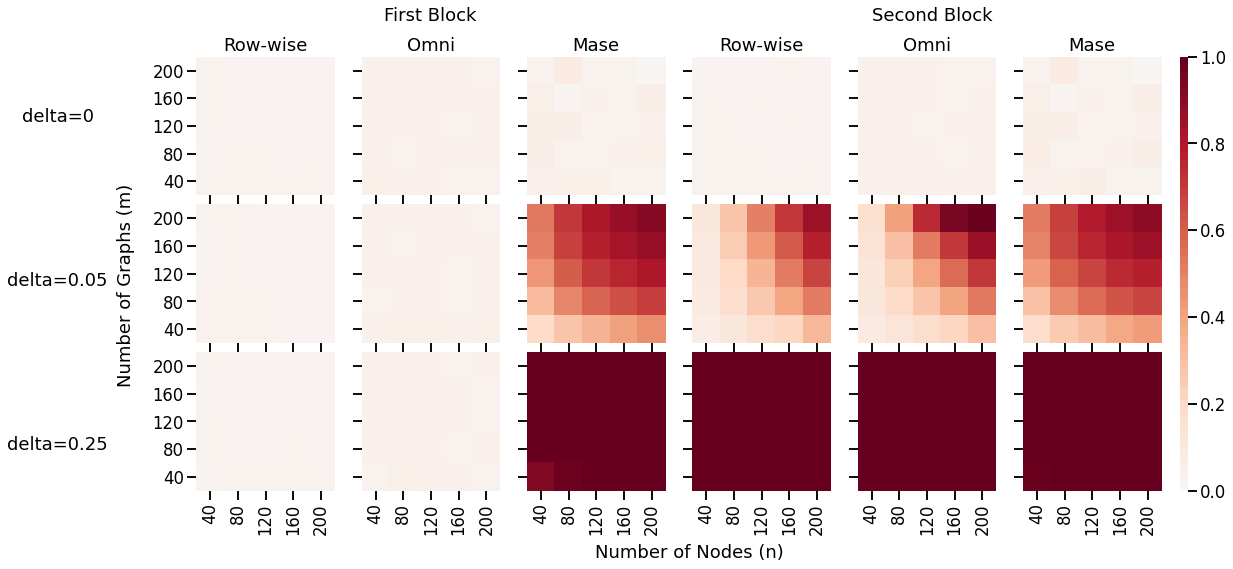

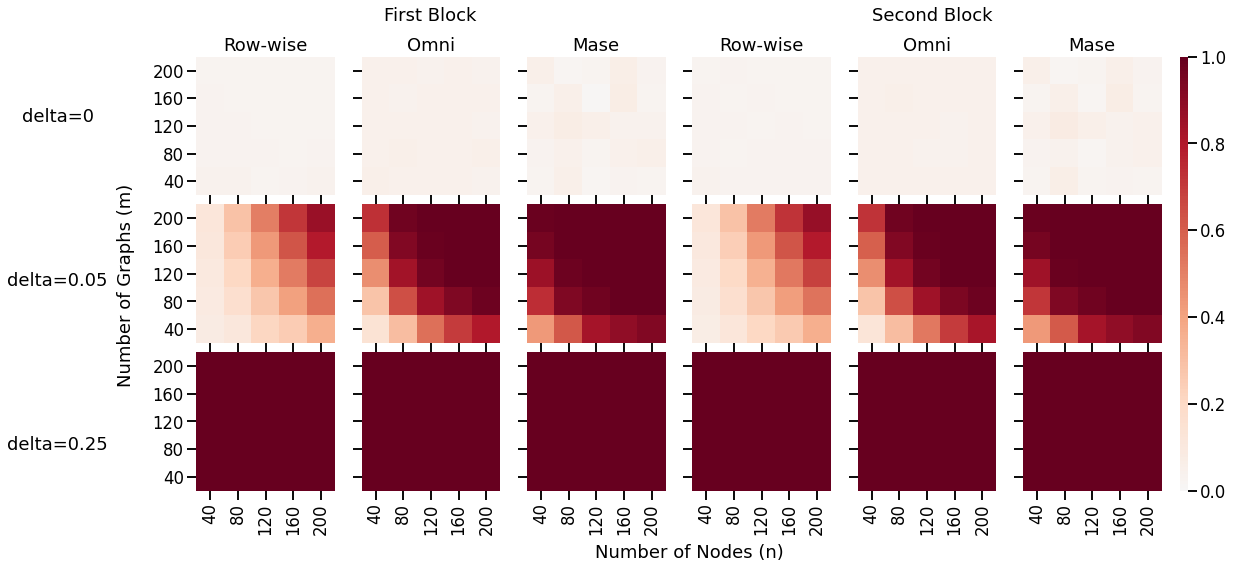

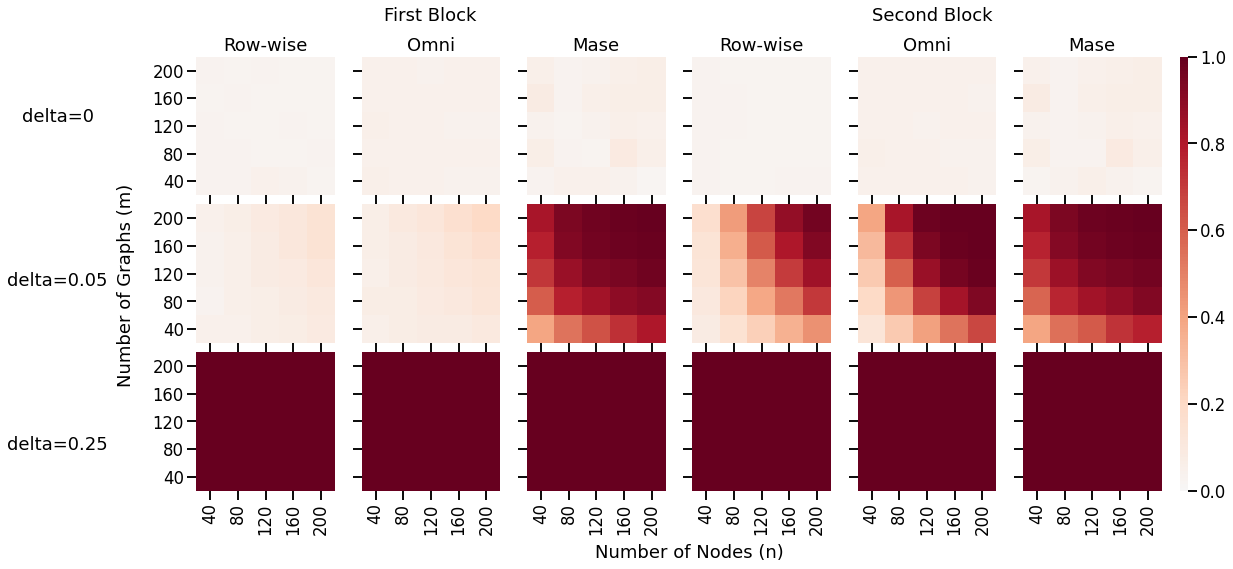

In [13]:
sns.set_context('talk')


for model in np.unique(df.model):
    fig, ax = plt.subplots(
        3, 
        7, 
        figsize=(15, 7),
        sharex=True,
        sharey=True,
        constrained_layout=True,
        gridspec_kw={"width_ratios": [1, 1, 1, 1, 1, 1, 0.05]},
    )

    gs = ax[-1, -1].get_gridspec()
    for ax_ in ax[:, -1]:
        ax_.remove()
    ax_leg = fig.add_subplot(gs[:, -1])

    col_names = ["Row-wise", 'Omni', 'Mase']
    
    tmp_df = df[df.model == model]

    for row, effect_size in enumerate(np.unique(tmp_df.effect_size)):
        for col, method in enumerate(tmp_df.columns[4:]):
            tmp = tmp_df[tmp_df.effect_size == effect_size][method]
            sns.heatmap(
                np.flipud(tmp.values.reshape(5, 5)),
                square=True,
                cmap='RdBu_r',
                center=0,
                cbar_ax=ax_leg,
                ax = ax[row, col],
                xticklabels=ns,
                yticklabels=ms[::-1],
                vmin=0,
                vmax=1
            )

            if row == 0:
                ax[row, col].set_title(col_names[col % 3])

    fig.text(0.26, 1.035, "First Block", va="center", ha="center")
    fig.text(0.725, 1.035, "Second Block", va="center", ha="center")

    fig.text(-0.085, 0.175, "delta=0.25", ha="center")
    fig.text(-0.085, 0.5, "delta=0.05", ha="center")
    fig.text(-0.085, 0.825, "delta=0", ha="center")

    fig.text(0.5, -0.03, "Number of Nodes (n)", va="center", ha="center")
    fig.text(-0.03, 0.5, "Number of Graphs (m)", va="center", rotation="vertical")
    
    fig.savefig(f"./figures/sbm_model_{model[-1]}.png", dpi=300, bbox_inches='tight')